# Advanced optimisation

In this section, we show how HEBO can be used for constrained and multi-objective optimisation

$$
\begin{array}{lll}
\text{minimize} && (f_1(x), \dots, f_m(x)) \\
\text{s.t.}     && c_1(x) < 0 \\
        ~       && c_2(x) < 0 \\
                && \dots \\
                && c_n(x) < 0
\end{array}
$$

## Objective function

We use benchmark functions from pymoo 

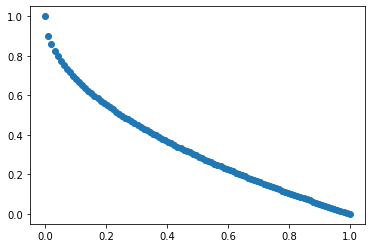

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from pymoo.factory import get_problem
from pymoo.util.plotting import plot
from pymoo.util.dominator import Dominator


problem = get_problem("zdt1", n_var = 5)
plot(problem.pareto_front())

dim = problem.n_var
num_obj = problem.n_obj
num_constr = problem.n_constr

We define a wrapper for our BO algorithm, the wrapper function takes in a `pd.DataFrame` and output an `np.ndarray` where left columns are objectives and constraint values are in right columns.

In [2]:
def obj(param : pd.DataFrame) -> np.ndarray:
    names = ['x' + str(i) for i in range(problem.n_var)]
    x   = param[names].values
    out = {}
    problem._evaluate(x,out)
    o = out['F'].reshape(x.shape[0], num_obj)
    if num_constr > 0:
        c = out['G'].reshape(x.shape[0], num_constr)
    else:
        c = np.zeros((x.shape[0],0))
    return np.hstack([o,c])

def extract_pf(points : np.ndarray) -> np.ndarray:
    dom_matrix = Dominator().calc_domination_matrix(points,None)
    is_optimal = (dom_matrix >= 0).all(axis = 1)
    return points[is_optimal]

## Design space

In [3]:
from hebo.design_space.design_space import DesignSpace

lb,ub  = problem.bounds()
params = [{'name' : 'x' + str(i), 'type' : 'num', 'lb' : lb[i], 'ub' : ub[i]} for i in range(dim)]
space  = DesignSpace().parse(params)
space.sample(5)

,x0,x1,x2,x3,x4
0,0.552404,0.423491,0.757016,0.320305,0.190718
1,0.529221,0.814676,0.024548,0.446910,0.966283
2,0.794715,0.599048,0.026609,0.035278,0.390373
3,0.269110,0.438545,0.801505,0.609330,0.195101
4,0.686324,0.240583,0.947298,0.964959,0.493572


## Bayesian optimisation

The `GeneralBO` class can be used to perform multi-objective bayesian optimisation

In [4]:
from hebo.optimizers.general import GeneralBO
conf = {}
conf['num_epochs'] = 100
opt = GeneralBO(space, num_obj, num_constr, model_conf = conf)
for i in range(50):
    rec = opt.suggest(n_suggestions=4)
    opt.observe(rec, obj(rec))

We'll plot the Pareto front given by BO algorithm, and compare it with random search, we can see that BO gives much better PF than random search

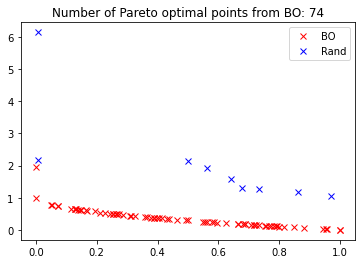

In [5]:
feasible_y = extract_pf(opt.y)
rand_y     = extract_pf(obj(space.sample(opt.y.shape[0])))
plt.plot(feasible_y[:,0], feasible_y[:,1], 'x', color = 'r', label = 'BO')
plt.plot(rand_y[:,0], rand_y[:,1], 'x', color = 'b', label = 'Rand')
plt.title('Number of Pareto optimal points from BO: %d' % feasible_y.shape[0])
plt.legend()

## Model accuracy checking

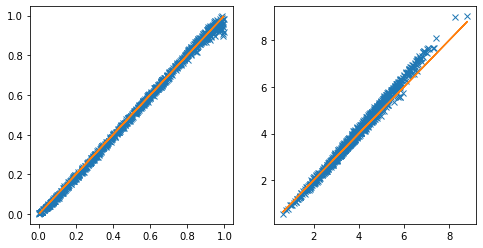

In [7]:
params = space.sample(1000)
values = obj(params)
with torch.no_grad():
    py,ps2 = opt.model.predict(*space.transform(params))

plt.figure(figsize = (8,4))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.plot(values[:,i], py[:,i], 'x')
    plt.plot(values[:,i], values[:,i])

## Copyright statment

Copyright (C) 2020. Huawei Technologies Co., Ltd. All rights reserved.

This program is free software; you can redistribute it and/or modify it under
the terms of the MIT license.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the MIT License for more details.